# Kernel Ridge Regression
## Edric Svarte

Ridge regression (RR) is a popular method used to estimate linear regression coefficients. Unlike the ordinary least squares (OLS) loss function, the RR objective function penalizes large weights (coefficients). This technique is believed to prevent overfitting by decreasing model variance, and may yield more accurate predictions than OLS. RR has many other benefits, though these are not mentioned here.

The "kernel trick" is a computationally convenient way to transform data. Kernel ridge regression (KRR) is simply a combination of both methods. In this tutorial, we explore the foundations of KRR, and demonstrate the effectiveness of this method via a simple Python implementation.

Our goal is to use KRR to learn the following quadratic function:

$$f(x1, \ x2)=10x_1^2 +3 x_2^2$$

Observed data are noisy, and are given by:

$$y = f(x) + \varepsilon, \ \varepsilon \sim G(0, \ 1e4)$$

We now simulate and plot the data.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Set the seed and the sample size
np.random.seed(787)
sample_size = 200

# Features are drawn from a uniform distribution
x1 = np.array(np.random.uniform(0, 100, sample_size))
x2 = np.array(np.random.uniform(0, 100, sample_size))

# Generate the response
y = 10 * x1 ** 2 + 3 * x2 ** 2 + np.random.normal(loc = 0, scale = 10000, size = sample_size)

# Standardize the data
x1_bar, x2_bar, y_bar = np.mean(x1), np.mean(x2), np.mean(y)
x1_sd, x2_sd, y_sd = np.std(x1), np.std(x2), np.std(y)

x1_standard = (x1 - x1_bar) / x1_sd
x2_standard = (x2 - x2_bar) / x2_sd
y_standard = (y - y_bar) / y_sd

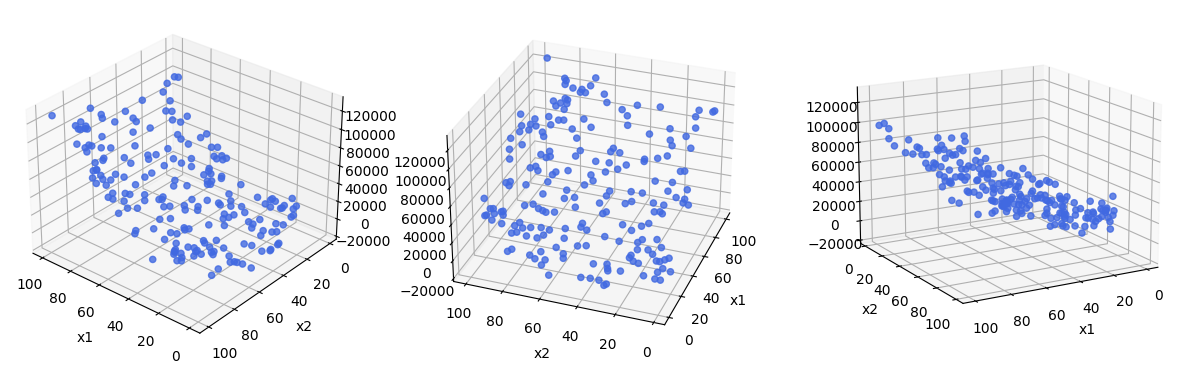

In [ ]:
# Plot the raw (unstandardized) data
fig1 = plt.figure(figsize = (15, 5))

ax1a = fig1.add_subplot(131, projection = '3d')
ax1a.scatter(x1, x2, y, color = 'royalblue', alpha = 0.8)
ax1a.set_xlabel('x1')
ax1a.set_ylabel('x2')
ax1a.view_init(elev = 30, azim = 130)

ax1b = fig1.add_subplot(132, projection = '3d')
ax1b.scatter(x1, x2, y, color = 'royalblue', alpha = 0.8)
ax1b.set_xlabel('x1')
ax1b.set_ylabel('x2')
ax1b.view_init(elev = 30, azim = 200)

ax1c = fig1.add_subplot(133, projection = '3d')
ax1c.scatter(x1, x2, y, color = 'royalblue', alpha = 0.8)
ax1c.set_xlabel('x1')
ax1c.set_ylabel('x2')
ax1c.view_init(elev = 15, azim = 60)

plt.show()

The plots above show the observed data from various angles; there seems to be some curvature. We can fit a plane to these points using ridge regression. A couple things to note:

* Here we set the penalty term hyperparameter arbitrarily to $\lambda = 2$
* In general, regularization should not be applied to the bias/intercept term. For basic RR, we can leave out the column of ones corresponding to the intercept (see why below)

With this in mind, we can fit the (basic) RR model.





In [ ]:
# Define the design matrix
X_standard = np.array([x1_standard, x2_standard]).T # Design matrix should be n x p

lambda_ridge = 2
penalty_mat = np.identity(X_standard.shape[1]) * lambda_ridge

# Obtain the coefficients
gamma_ridge = np.linalg.inv(X_standard.T @ X_standard + penalty_mat) @ X_standard.T @ y_standard

Keep in mind that matrix inversion (as above) is inefficient. Computational efficiency is important, but not critical in this tutorial.

Now, how do we recover the original coefficients? Notice that the coefficients calculated above are on the incorrect scale (the standardized scale).

In fact, we have fit the following model:

$$
\frac{y - \bar{y}}{\sigma_y}=\gamma_1 \frac{x_1 - \bar{x}_1}{\sigma_1} + \gamma_2 \frac{x_2 - \bar{x}_2}{\sigma_2}
$$

Rearranging:

$$
\frac{y - \bar{y}}{\sigma_y}=\frac{\gamma_1}{\sigma_1}(x_1 - \bar{x}_1) + \frac{\gamma_2}{\sigma_2} (x_2 - \bar{x}_2)
$$

$$
\implies y - \bar{y}=\frac{\sigma_y \gamma_1}{\sigma_1}(x_1 - \bar{x}_1) + \frac{\sigma_y \gamma_2}{\sigma_2} (x_2 - \bar{x}_2)
$$

Expanding the right-hand side, we obtain:

$$
y - \bar{y}=-\frac{\sigma_y \gamma_1}{\sigma_1}\bar{x}_1-\frac{\sigma_y \gamma_2}{\sigma_2}\bar{x}_2+ \frac{\sigma_y \gamma_1}{\sigma_1}x_1 + \frac{\sigma_y \gamma_2}{\sigma_2}x_2
$$

$$
\implies y =\bar{y}-\frac{\sigma_y \gamma_1}{\sigma_1}\bar{x}_1-\frac{\sigma_y \gamma_2}{\sigma_2}\bar{x}_2+ \frac{\sigma_y \beta_1}{\gamma_1}x_1 + \frac{\sigma_y \gamma_2}{\sigma_2}x_2
$$

Now, let $\beta_i=\frac{\sigma_y \gamma_i}{\sigma_i}$

$$
\implies y = \bar{y}-\beta_1 \bar{x}_1-\beta_2 \bar{x}_2+\beta_1x_1 + \beta_2x_2
$$

$$
\implies y = (\bar{y}-\beta_1 \bar{x}_1-\beta_2 \bar{x}_2)+\beta_1x_1 + \beta_2x_2
$$

The last expression looks like a typical linear regression model with an intercept given by:

$$
\beta_0 = \bar{y}-\beta_1 \bar{x}_1-\beta_2 \bar{x}_2
$$

We now have an intercept term; hence there was no need to include a column of ones in the design matrix. Now, let's transform the coefficients.

In [ ]:
# Transform the coefficients back to the original scale
beta_ridge = gamma_ridge * y_sd / [x1_sd, x2_sd]
intercept_ridge = y_bar - beta_ridge[0] * x1_bar - beta_ridge[1] * x2_bar
beta_ridge = np.concatenate([[intercept_ridge], beta_ridge], axis = 0)

# Obtain the fitted values and the R-squared coefficient
X_raw = np.array([np.ones_like(x1), x1, x2]).T
y_fit = X_raw @ beta_ridge
R_squared = 1 - np.linalg.norm(y - y_fit) ** 2 / np.linalg.norm(y - np.mean(y)) ** 2
print(f'R-squared: {round(R_squared, 3)}')

R-squared: 0.873


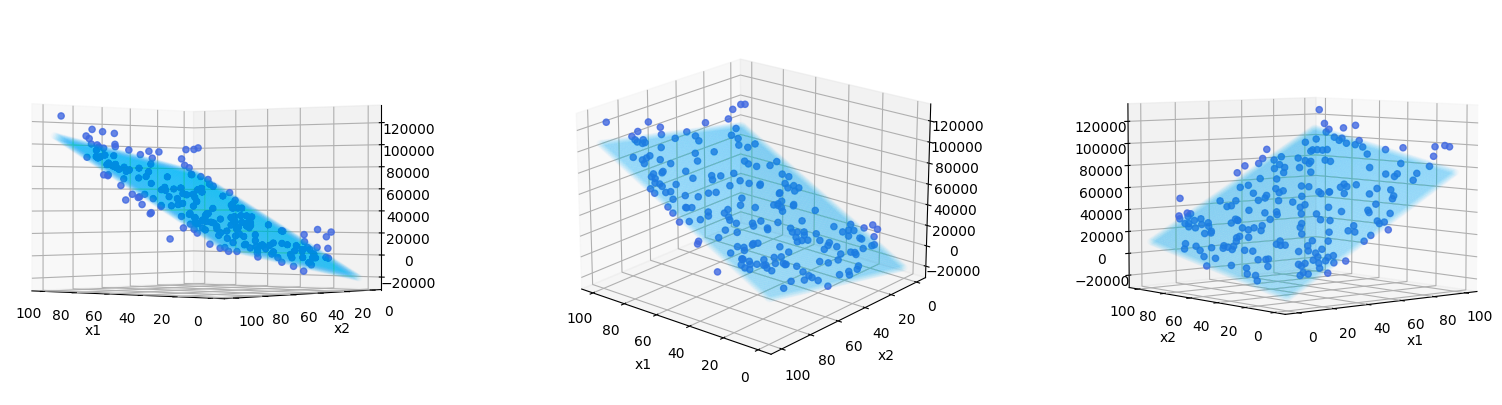

In [ ]:
# Plot the fitted plane
x1_seq = x2_seq = np.linspace(0, 100, 100)
x1_seq, x2_seq = np.meshgrid(x1_seq, x2_seq)
x1_seq, x2_seq = x1_seq.ravel(), x2_seq.ravel()

X_pred = np.array((np.ones_like(x1_seq), x1_seq, x2_seq)).T
y_pred = X_pred @ beta_ridge

fig2 = plt.figure(figsize = (20, 5))

ax2a = fig2.add_subplot(131, projection = '3d')
ax2a.scatter(x1, x2, y, color = 'royalblue', alpha = 0.8)
ax2a.scatter(x1_seq, x2_seq, y_pred, color = 'deepskyblue', alpha = 0.02)
ax2a.set_xlabel('x1')
ax2a.set_ylabel('x2')
ax2a.view_init(elev = 0, azim = 130)

ax2b = fig2.add_subplot(132, projection = '3d')
ax2b.scatter(x1, x2, y, color = 'royalblue', alpha = 0.8)
ax2b.scatter(x1_seq, x2_seq, y_pred, color = 'deepskyblue', alpha = 0.02)
ax2b.set_xlabel('x1')
ax2b.set_ylabel('x2')
ax2b.view_init(elev = 20, azim = 130)

ax2c = fig2.add_subplot(133, projection = '3d')
ax2c.scatter(x1, x2, y, color = 'royalblue', alpha = 0.8)
ax2c.scatter(x1_seq, x2_seq, y_pred, color = 'deepskyblue', alpha = 0.02)
ax2c.set_xlabel('x1')
ax2c.set_ylabel('x2')
ax2c.view_init(elev = 5, azim = 230)

plt.show()


The plane appears to be a decent fit for data. $R^2=0.87$ suggests that our model captures 87% of the variation in the observed data. However, the kernel trick may provide a better fit. First, we require some background.

Say we have two vectors, $x, \ y \in S \subseteq \mathbb{R}^n$. The dot product between $x$ and $y$ is given by $\langle x, \ y \rangle$. Suppose we now apply a transformation, $g$, to this inner product. Note that $g$ must satisfy certain conditions (omitted here). Remarkably, the following result holds:   

$$g(\langle x, \ y \rangle)=\langle \phi(x), \ \phi(y) \rangle$$

The "feature mapping," $\phi: S \longmapsto H$, maps vectors in $S$ to some higher-dimensional Hilbert space, $H$. In other words, applying $g$ to $\langle x, \ y \rangle$ is equivalent to first calculating $\phi(x)$ and $\phi(y)$, and then computing $\langle \phi(x), \ \phi(y) \rangle$. This result is computationally convenient since $\dim(H)$ may be very large or even infinite. The diagram below helps illustrate the concept.

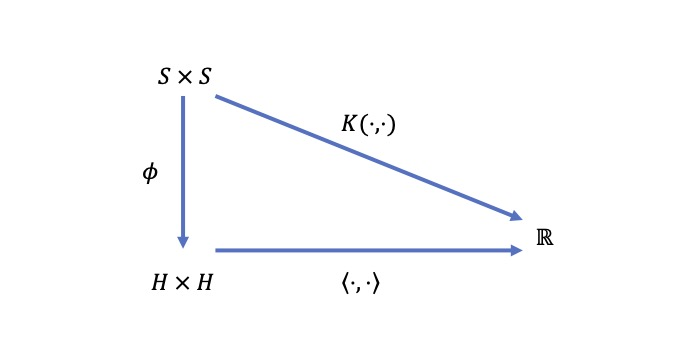


However, it is not immediately clear that this technique may be applied to ridge regression. Suppose $y\in \mathbb{R}^n$ denotes the vector of responses/labels, and that our observations are stored in a design matrix, $X\in \mathbb{R}^{n \times p}$. Recall the RR optimizer:

$$\widehat{\beta}_{RR} = (X^TX+\lambda I)^{-1}X^Ty$$

However, $X^TX$ is a covariance matrix that estimates how features co-vary, not observations. On the other hand, $[XX^T]_{ij}=\langle x_i, \ x_j \rangle$. Clearly, we need $XX^T$ to apply the kernel trick. Fortunately, we can express the weight vector in terms of $XX^T$, as shown below:

$$X = X \implies X^T = X^T$$

$$(X^TX+\lambda I)X^T=(X^TX+\lambda I)X^T\implies(X^TXX^T+\lambda X^T)=(X^TX+\lambda I)X^T$$

$$
X^T(XX^T+\lambda I)
=(X^TX+\lambda I)X^T$$

$$
X^T(XX^T+\lambda I)(XX^T+\lambda I)^{-1}
=(X^TX+\lambda I)X^T(XX^T+\lambda I)^{-1}$$

$$
X^T=(X^TX+\lambda I)X^T(XX^T+\lambda I)^{-1}$$

$$
(X^TX+\lambda I)^{-1}X^T=(X^TX+\lambda I)^{-1}(X^TX+\lambda I)X^T(XX^T+\lambda I)^{-1}$$

Finally,

$$
(X^TX+\lambda I)^{-1}X^T=X^T(XX^T+\lambda I)^{-1}$$

$$
\implies \widehat{\beta}_{RR}=(X^TX+\lambda I)^{-1}X^Ty \equiv X^T(XX^T+\lambda I)^{-1}y
$$

The last expression is not useful on its own. Indeed, $X^T$ is still unknown. However, recall that the fitted values are given by: $\widehat{y} = X\widehat{\beta}_{RR}$

$$
\implies \widehat{y} = X\widehat{\beta}_{RR} = XX^T(XX^T+\lambda I)^{-1}y
$$

Using our transformation $g$, the fitted values become:

$$\widehat{y}=g(XX^T)(g(XX^T)+\lambda I)^{-1}y$$


Where $g$ is applied element-wise to $XX^T$. Similarly, the predicted values for a new set of observations, $X_{NEW}$, is given by:

$$\widehat{y}_{NEW}=X_{NEW}X^T(XX^T+\lambda I)^{-1}y$$

Once again, $X_{NEW}X^T$ is an inner product matrix. Applying our transformation $g$, the predicted values become:

$$\widehat{y}_{NEW}=g(X_{NEW}X^T)(g(XX^T)+\lambda I)^{-1}y$$

In this example, we choose $g: x \longmapsto x ^ 2$. This kernel is known as a "polynomial kernel." Notice that $XX^T \in \mathbb{R}^{n \times n}$, while $X^TX \in \mathbb{R}^{p \times p}$. This method is particularly efficient when $p>n$.

Let's see the kernel trick in action. This time, we fit an intercept. Unfortunately, this means the intercept will be penalized. However, fitting the model in this way will not make a large difference, and will ensure simplicity.



In [ ]:
# Add a column of 1s to the standardized design matrix
X_standard = np.concatenate([np.ones((X_standard.shape[0], 1)), X_standard], axis = 1)

# Define the matrix of transformed inner products
gram_matrix = (X_standard @ X_standard.T) ** 2
penalty_mat_kernel = np.identity(X_standard.shape[0]) * lambda_ridge

# W is an intermediate
W = np.linalg.inv(gram_matrix + penalty_mat_kernel) @ y_standard

# Obtain the predicted values (transform inputs first)
x1_seq_standard = (x1_seq - np.mean(x1_seq)) / np.std(x1_seq)
x2_seq_standard = (x2_seq - np.mean(x2_seq)) / np.std(x2_seq)
X_pred_kernel = np.array([np.ones_like(x1_seq_standard), x1_seq_standard, x2_seq_standard]).T

# Re-scale the predictions
y_pred_kernel = y_bar + y_sd * (((X_standard @ X_pred_kernel.T) ** 2).T @ W)

# Obtain the fitted values (re-scale these too)
y_fit_kernel = y_bar + y_sd * (gram_matrix @ W)
R_squared_kernel = 1 - np.linalg.norm(y - y_fit_kernel) ** 2 / np.linalg.norm(y - y_bar) ** 2
print(f'R-squared: {round(R_squared_kernel, 3)}')

R-squared: 0.91


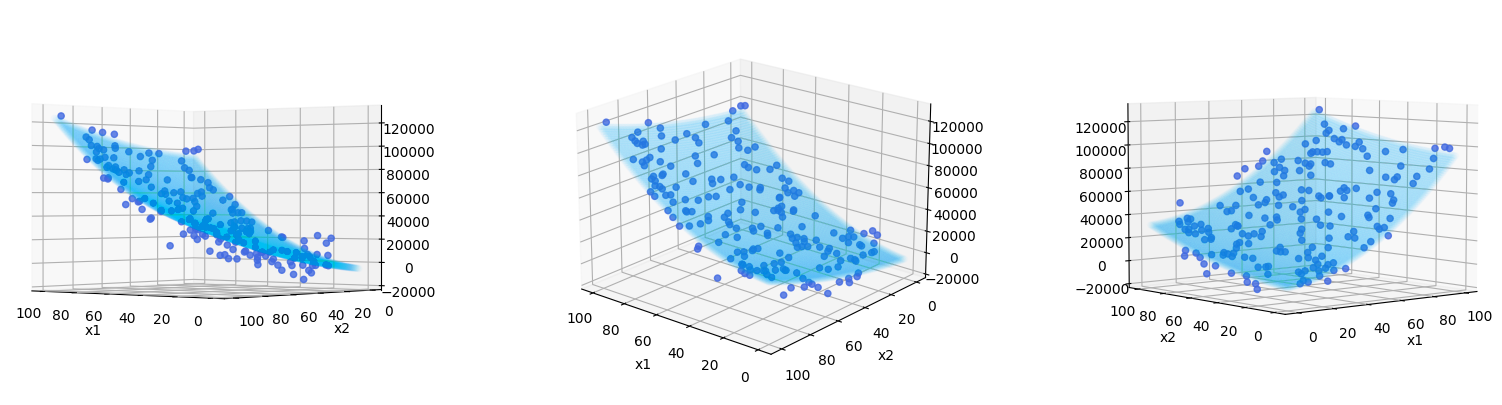

In [ ]:
# Plot results (original scale)
fig3 = plt.figure(figsize = (20, 5))

ax3a = fig3.add_subplot(131, projection = '3d')
ax3a.scatter(x1, x2, y, color = 'royalblue', alpha = 0.8)
ax3a.scatter(x1_seq, x2_seq, y_pred_kernel, color = 'deepskyblue', alpha = 0.02)
ax3a.set_xlabel('x1')
ax3a.set_ylabel('x2')
ax3a.view_init(elev = 0, azim = 130)

ax3b = fig3.add_subplot(132, projection = '3d')
ax3b.scatter(x1, x2, y, color = 'royalblue', alpha = 0.8)
ax3b.scatter(x1_seq, x2_seq, y_pred_kernel, color = 'deepskyblue', alpha = 0.02)
ax3b.set_xlabel('x1')
ax3b.set_ylabel('x2')
ax3b.view_init(elev = 20, azim = 130)

ax3c = fig3.add_subplot(133, projection = '3d')
ax3c.scatter(x1, x2, y, color = 'royalblue', alpha = 0.8)
ax3c.scatter(x1_seq, x2_seq, y_pred_kernel, color = 'deepskyblue', alpha = 0.02)
ax3c.set_xlabel('x1')
ax3c.set_ylabel('x2')
ax3c.view_init(elev = 5, azim = 230)

plt.show()

This time, $R^2 =0.91$. The fit has improved. Choosing an appropriate kernel was simple in this case since we knew the generating function. As with any other hyperparameter, various techniques exist to guide kernel choice.